In [157]:
include("io.jl")
include("types.jl")
include("utils.jl")
include("preprocessing.jl")
include("svd_model.jl")
#include("cluster_sim.jl")
using Clustering
using LinearAlgebra
using DataFrames
using Plots

In [180]:
println("Starting up...")

path="data/ml-32m/"

#args = parse_args()
#args=Dict("k"=>2, "num_clusters"=>6, "train_ratio"=>0.8, "min_ratings_per_user"=>800, "min_ratings_per_movie"=>2500)
args=Dict("k"=>4, "num_clusters"=>12, "train_ratio"=>0.8, "min_ratings_per_user"=>1000, "min_ratings_per_movie"=>2500)
config = ClusteringConfig(k=args["k"], num_clusters=args["num_clusters"], train_ratio=args["train_ratio"], min_ratings_per_user=args["min_ratings_per_user"], min_ratings_per_movie=args["min_ratings_per_movie"])
config = ClusteringConfig(k=args["k"], num_clusters=args["num_clusters"], train_ratio=args["train_ratio"], min_ratings_per_user=args["min_ratings_per_user"], min_ratings_per_movie=args["min_ratings_per_movie"])
validate_config(config)

df = load_ratings(path*"ratings.csv")
ratings_data=preprocess_ratings(df, config.min_ratings_per_user, config.min_ratings_per_movie)

println("Loaded $(size(df, 1)) ratings")
println("Loaded $(length(ratings_data.user_map)) users")
(train_users, test_users) = split_users(Set(keys(ratings_data.user_map)), config.train_ratio)

dataset_train = get_data_for_user_subset(ratings_data, Set(train_users))
dataset_test= get_data_for_user_subset(ratings_data, Set(test_users))

#U, S, V = svd(dataset_train.imputed_matrix)
svd_result = create_svd_model(dataset_train.imputed_matrix)
truncated_svd_result = truncate_svd(svd_result, config.k)
println("Truncated SVD to $(config.k) dimensions")

println("Split $(length(train_users)) train users and $(length(test_users)) test users")
println("train_users: $(train_users)")

S=[svd_result.S[i, i] for i in 1:size(svd_result.S, 1)]

println("dimensions of matrices: U=$(size(svd_result.U)), S=$(size(svd_result.S)), V=$(size(svd_result.V))")
p1=plot(cumsum(S) ./ sum(S), legend=false, xlabel="Number of singular values", ylabel="Fraction of total variance", title="Fraction of total variance vs. number of singular values")
savefig(p1, "cumulative_variance_plot.png")
p2=plot(S./sum(S), xlim=[0,10],legend=false, xlabel="Number of singular values", ylabel="Fraction of total variance", title="Fraction of total variance vs. number of singular values")
savefig(p2, "singular_values_plot.png")


U_k=truncated_svd_result.U

kmeans_result = kmeans(transpose(U_k), config.num_clusters)

# Extract the cluster assignments for each user
cluster_assignments = kmeans_result.assignments

# Print the cluster centers
println("Cluster Centers:")
println(kmeans_result.centers)
p3=scatter(U_k[:, 1], U_k[:, 2], group=cluster_assignments, xlabel="Feature 1", ylabel="Feature 2", title="User Clusters")
savefig(p3, "user_clusters.png")


#cluster_movie_forecasts=transpose(kmeans_result.centers)*S_k*transpose(V_k)
println("kmeans_result.centers: $(kmeans_result.centers)")
cluster_movie_forecasts=predict_from_users(transpose(kmeans_result.centers), truncated_svd_result)
println("Cluster movie forecasts: $(size(cluster_movie_forecasts))")

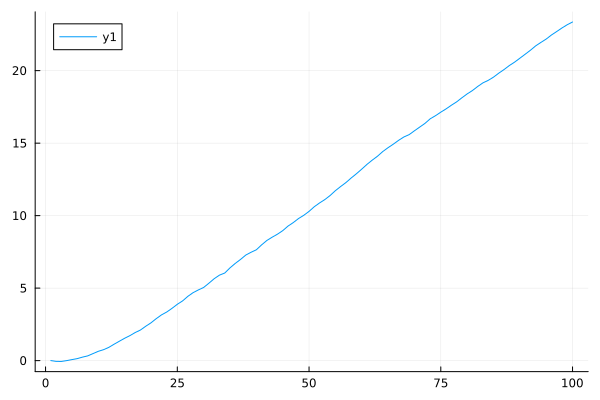

In [181]:
include("cluster_sim.jl")

π=DirichletPolicy(ones(config.num_clusters),kmeans_result.centers,cluster_movie_forecasts)
all_user_tracking=run_all_users_episodes(π, dataset_test, kmeans_result, cluster_movie_forecasts,config.num_clusters,100)
sum_tracking=mean([x[!,"reward"] for x in all_user_tracking])
tracking=[x[!,"reward"] for x in all_user_tracking] 
all_user_tracking[1]
pick_tracking1=sum_tracking
plot(cumsum(sum_tracking))

In [185]:

π=RandomClusterPolicy(config.num_clusters,kmeans_result.centers,cluster_movie_forecasts)
all_user_tracking_random=run_all_users_episodes(π, dataset_test, kmeans_result, cluster_movie_forecasts,config.num_clusters,100)
sum_tracking_random=mean([x[!,"reward"] for x in all_user_tracking_random])
tracking_random=[x[!,"reward"] for x in all_user_tracking_random]
all_user_tracking[1]
pick_tracking1=sum_tracking
p4 = plot(sum_tracking - sum_tracking_random, title="Average difference in reward compared to benchmark", label=["One Step Reward Difference"], legend=:topright, xlabel="Step", ylabel="One Step Reward", titlefontsize=8)
savefig(p4, "comparison_sum_tracking.png")
p5 = plot(cumsum(sum_tracking) - cumsum(sum_tracking_random), title="Average Difference in Cumulative Reward Compared to Benchmark", label=["Cumulative Reward Difference"], legend=:topright, xlabel="Step", ylabel="Cumulative Reward", titlefontsize=8)
savefig(p5, "cusum_comparison_sum_tracking.png")

p6 = plot(cumsum(sum_tracking), title="Average Cumulative Reward", label=["Average Cumulative Dirichlet sampled Reward"], legend=:topright, xlabel="Step", ylabel="Cumulative Reward", titlefontsize=8)
p6=plot!(cumsum(sum_tracking_random), title="Average Cumulative Reward", label=["Average Cumulative Random Cluster Reward"], legend=:topright, xlabel="Step", ylabel="Cumulative Reward", titlefontsize=8)
savefig(p6, "both_cumulative_sum_tracking.png")  


"/Users/stirlitz/ncGitHub/AA228/Final Project/both_cumulative_sum_tracking.png"

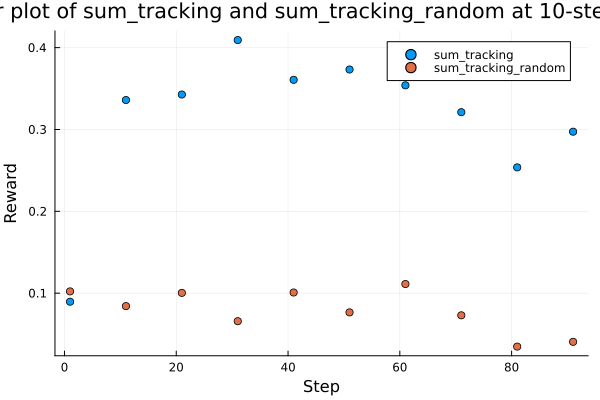

In [143]:
steps = 1:10:length(sum_tracking)
scatter(steps, sum_tracking[steps], label="sum_tracking", xlabel="Step", ylabel="Reward", title="Scatter plot of sum_tracking and sum_tracking_random at 10-step intervals")
scatter!(steps, sum_tracking_random[steps], label="sum_tracking_random")
#savefig("scatter_plot_10_step_intervals.png")

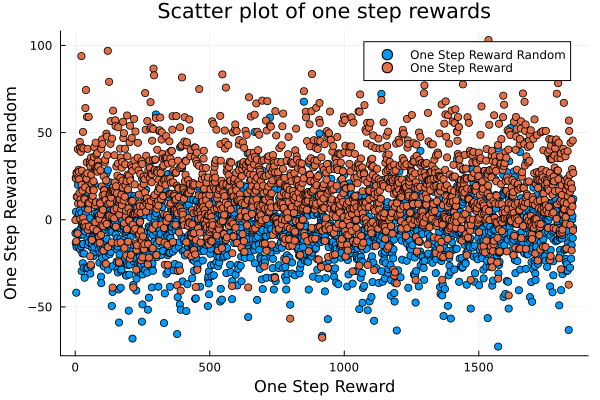

In [170]:
step=100
points=[cumsum(x)[step] for x in (tracking)]
points_random=[cumsum(x)[step] for x in (tracking_random)]

scatter(1:length(points), points_random, label="One Step Reward Random", xlabel="One Step Reward Random", ylabel="One Step Reward", title="Scatter plot of one step rewards") 
scatter!(1:length(points), points, label="One Step Reward", xlabel="One Step Reward", ylabel="One Step Reward Random", title="Scatter plot of one step rewards")

In [ ]:
a=5

BoundsError: BoundsError: attempt to access 1112-element Vector{Vector{Float64}} at index [1:1112, 5]

In [12]:
all_user_tracking[1]

Row,forecast_quality,reward,movie,action,error,policy_counts,user,i
,Float64,Float64,Int64,Int64,Float64,Array…,Int64,Int64
1,0.0965037,-0.97479,727,727,1.31464,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1,1
2,0.312453,1.52521,1887,1887,1.65372,"[1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]",1,2
3,-0.136615,1.52521,1059,1059,1.06509,"[1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]",1,3
4,-0.00164065,0.0252101,2091,2091,2.24418e-5,"[1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]",1,4
5,0.0721682,-0.47479,26,26,0.220559,"[1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]",1,5
6,-0.0316499,-0.47479,1616,1616,0.225292,"[1.0, 1.0, 1.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]",1,6
7,0.0,0.52521,1187,1187,0.143354,"[1.0, 1.0, 1.0, 5.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]",1,7
8,0.00329674,0.0252101,453,453,0.00386103,"[1.0, 1.0, 1.0, 5.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0]",1,8
9,0.0,0.52521,1825,1825,0.205135,"[1.0, 1.0, 2.0, 5.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0]",1,9
